# Segmentation

In [46]:
# !pip install pycocotools
!pip install albumentations

  Using cached albumentations-2.0.8-py3-none-any.whl.metadata (43 kB)
  Using cached pydantic-2.12.3-py3-none-any.whl.metadata (87 kB)
  Using cached albucore-0.0.24-py3-none-any.whl.metadata (5.3 kB)
  Using cached opencv_python_headless-4.12.0.88-cp37-abi3-macosx_13_0_arm64.whl.metadata (19 kB)
  Using cached simsimd-6.5.3-cp313-cp313-macosx_11_0_arm64.whl.metadata (70 kB)
  Using cached numpy-2.2.6-cp313-cp313-macosx_14_0_arm64.whl.metadata (62 kB)
  Using cached annotated_types-0.7.0-py3-none-any.whl.metadata (15 kB)
  Using cached typing_inspection-0.4.2-py3-none-any.whl.metadata (2.6 kB)
Using cached albumentations-2.0.8-py3-none-any.whl (369 kB)
Using cached albucore-0.0.24-py3-none-any.whl (15 kB)
Using cached opencv_python_headless-4.12.0.88-cp37-abi3-macosx_13_0_arm64.whl (37.9 MB)
Using cached numpy-2.2.6-cp313-cp313-macosx_14_0_arm64.whl (5.1 MB)
Using cached pydantic-2.12.3-py3-none-any.whl (462 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 3.4 MB/s  0:00:00 e

In [47]:
import os
import json
import random
import numpy as np
from pathlib import Path
from PIL import Image
import matplotlib.pyplot as plt

from pycocotools.coco import COCO

import albumentations as A
import torchvision.transforms as transforms

In [42]:
from src.dataset import SeaTurtleDataset, download_dataset
# from src.arcface import ArcFace
from src.utils import get_device

SEED = 42
random.seed(SEED)

In [ ]:
paths = download_dataset()
images_path = paths['images_path']
paths

Dataset downloaded and extracted to: /Users/nhut/.cache/kagglehub/datasets/wildlifedatasets/seaturtleid2022/versions/4


{'path': '/Users/nhut/.cache/kagglehub/datasets/wildlifedatasets/seaturtleid2022/versions/4',
 'images_path': '/Users/nhut/.cache/kagglehub/datasets/wildlifedatasets/seaturtleid2022/versions/4/turtles-data/data',
 'annotations_path': '/Users/nhut/.cache/kagglehub/datasets/wildlifedatasets/seaturtleid2022/versions/4/turtles-data/data/annotations.json',
 'metadata': '/Users/nhut/.cache/kagglehub/datasets/wildlifedatasets/seaturtleid2022/versions/4/turtles-data/data/metadata.csv',
 'metadata_splits': '/Users/nhut/.cache/kagglehub/datasets/wildlifedatasets/seaturtleid2022/versions/4/turtles-data/data/metadata_splits.csv'}

## Preview Segmentation data

### Load annotation

In [35]:
# original annotations file
# annotations_path = paths["annotations_path"]

# sub-dataset annotations file
annotations_path = "./data/seaturtleid2022-subset/annotations.json"

# Load COCO-style API for convenience
coco = COCO(annotations_path)

# Get category IDs
cat_ids = coco.getCatIds()
cats = coco.loadCats(cat_ids)
print("Categories:", [c["name"] for c in cats])

# with open(annotations_path, "r") as f:
#     coco = json.load(f)

# print("Images:", len(coco["images"]))
# print("Annotations:", len(coco["annotations"]))
# print("Categories:", coco["categories"])

# display(coco.keys())
# display(coco['images'][0])
# display(coco['annotations'][0].keys())

loading annotations into memory...
Done (t=0.19s)
creating index...
index created!
Categories: ['turtle', 'flipper', 'head']


### Visuallize

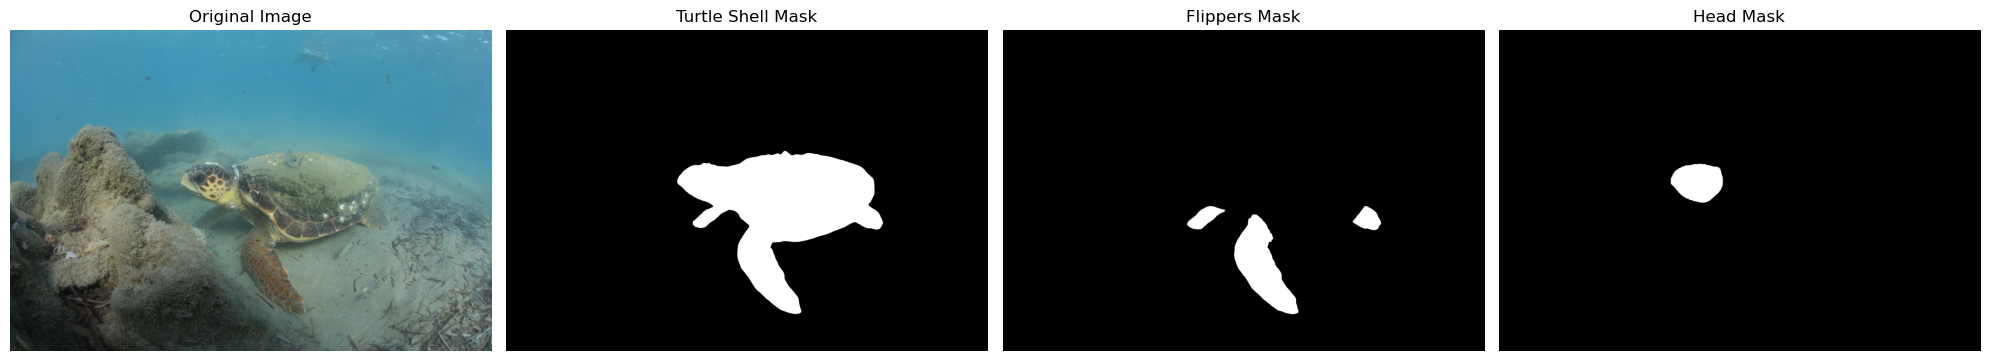

In [ ]:
# Randomly choose one image
img_id = random.choice(coco.getImgIds())
img_info = coco.loadImgs(img_id)[0]
img_path = os.path.join(images_path, img_info["file_name"])

# Load image
image = np.array(Image.open(img_path).convert("RGB"))

# Get all annotations for this image
ann_ids = coco.getAnnIds(imgIds=[img_id])
anns = coco.loadAnns(ann_ids)

# Prepare blank masks for each category
height, width = image.shape[:2]
mask_dict = {"turtle": np.zeros((height, width), dtype=np.uint8),
             "flipper": np.zeros((height, width), dtype=np.uint8),
             "head": np.zeros((height, width), dtype=np.uint8)}

# Build masks by category
for ann in anns:
    cat_id = ann["category_id"]
    cat_name = coco.loadCats(cat_id)[0]["name"]
    mask = coco.annToMask(ann)
    if cat_name in mask_dict:
        mask_dict[cat_name] = np.maximum(mask_dict[cat_name], mask)  # combine overlapping masks

# Visualization
fig, axs = plt.subplots(1, 4, figsize=(20, 6))

axs[0].imshow(image)
axs[0].set_title("Original Image")
axs[0].axis("off")

axs[1].imshow(mask_dict["turtle"], cmap="gray")
axs[1].set_title("Turtle Shell Mask")
axs[1].axis("off")

axs[2].imshow(mask_dict["flipper"], cmap="gray")
axs[2].set_title("Flippers Mask")
axs[2].axis("off")

axs[3].imshow(mask_dict["head"], cmap="gray")
axs[3].set_title("Head Mask")
axs[3].axis("off")

plt.tight_layout()
plt.show()

## Pre-train Preparation

In [ ]:
# --- Configuration ---
IMG_SIZE = 224
DATA_DIR = './data/seaturtleid2022-subset'

model_dir = './models'
Path(model_dir).mkdir(parents=True, exist_ok=True)
model_save_path = f'{model_dir}/filtered_closed_arcface_swin_b.pth'

train_csv_path = os.path.join(DATA_DIR, "metadata_closed_set_splits_train.csv")
eval_csv_path = os.path.join(DATA_DIR, "metadata_closed_set_splits_valid.csv")
test_csv_path = os.path.join(DATA_DIR, "metadata_closed_set_splits_test.csv")

In [ ]:
resize_transform = A.Resize(height=IMG_SIZE, width=IMG_SIZE, always_apply=True)

train_transform = A.Compose([
            resize_transform,
            A.HorizontalFlip(), # default p=0.5
            A.RandomBrightnessContrast(), # default p=0.2
            A.Rotate(), # default p=0.5
            A.ToTensorV2()  # Convert to PyTorch tensor (C, H, W)
        ], additional_targets={'mask': 'mask'})

test_transform = A.Compose([
    resize_transform,
    A.ToTensorV2(),
])